Loading and preprocessing data...
Building and training model...


c:\Users\Angelika Vergara\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 1787s 2s/step - accuracy: 0.8122 - loss: 0.4312 - val_accuracy: 0.8747 - val_loss: 0.2950 - learning_rate: 0.0010
Epoch 2/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 1912s 2s/step - accuracy: 0.8637 - loss: 0.3262 - val_accuracy: 0.8627 - val_loss: 0.3433 - learning_rate: 0.0010
Epoch 3/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 1986s 2s/step - accuracy: 0.8735 - loss: 0.3039 - val_accuracy: 0.8815 - val_loss: 0.2719 - learning_rate: 0.0010
Epoch 4/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 2062s 3s/step - accuracy: 0.8820 - loss: 0.2880 - val_accuracy: 0.8874 - val_loss: 0.2667 - learning_rate: 0.0010
Epoch 5/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 2095s 3s/step - accuracy: 0.8908 - loss: 0.2696 - val_accuracy: 0.8853 - val_loss: 0.2613 - learning_rate: 0.0010
Epoch 6/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 2012s 2s/step - accuracy: 0.8871 - loss: 0.2676 - val_accuracy: 0.8911 - val_loss: 0.2638 - learning_rate: 0.0010
Epoch 7/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 1855s 2s/step - accuracy: 0.8938 - l

Evaluating model...
102/102 ━━━━━━━━━━━━━━━━━━━━ 53s 476ms/step

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.91      0.86      0.89      1623
       Toxic       0.87      0.91      0.89      1622

    accuracy                           0.89      3245
   macro avg       0.89      0.89      0.89      3245
weighted avg       0.89      0.89      0.89      3245

Accuracy: 0.8888
Precision: 0.8702
Recall: 0.9137
F1 Score: 0.8914


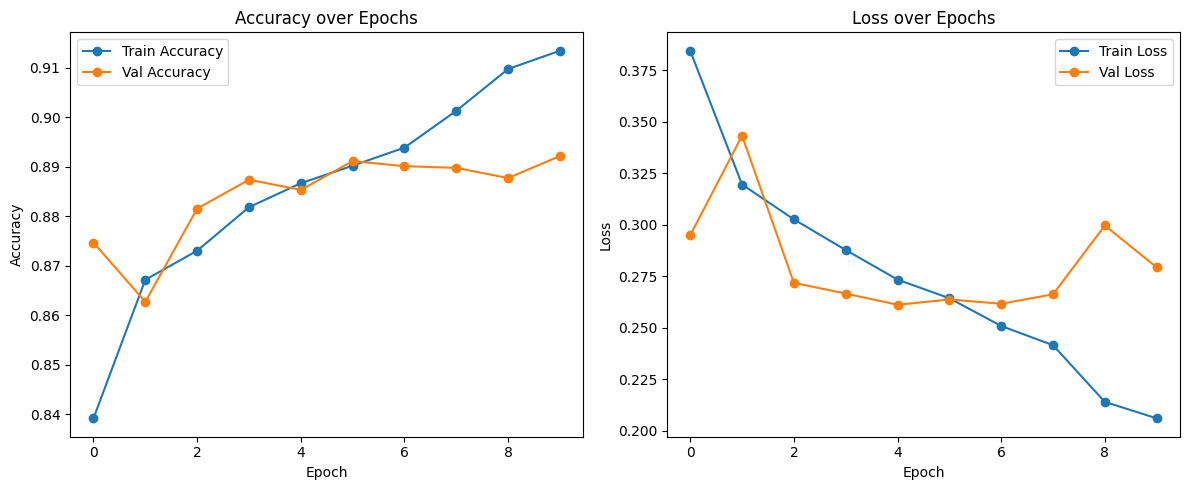

In [3]:
import numpy as np
import pandas as pd
import spacy
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, class_weight
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load SpaCy with 300d vectors
nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

def load_and_balance_datasets():
    # Load training data
    train_df = pd.read_csv('./data/train.csv')
    
    # Convert multi-labels to binary (toxic = 1 if any subtype is toxic)
    train_df['toxic'] = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
    train_df = train_df[['comment_text', 'toxic']]
    
    # Balance data via downsampling
    df_majority = train_df[train_df.toxic == 0]
    df_minority = train_df[train_df.toxic == 1]
    df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)
    balanced_df = pd.concat([df_majority_downsampled, df_minority]).reset_index(drop=True)
    
    return balanced_df

def preprocess_texts(texts):
    processed_texts = []
    for doc in nlp.pipe(texts, batch_size=500):
        tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        processed_texts.append(" ".join(tokens))
    return processed_texts

def prepare_model_input(df):
    df['processed_text'] = preprocess_texts(df['comment_text'].tolist())
    unique_words = set(word for text in df['processed_text'] for word in text.split())
    tokenizer = {word: i+1 for i, word in enumerate(unique_words)}
    sequences = [[tokenizer.get(word, 0) for word in text.split()] for text in df['processed_text']]
    
    # Ensure sequences are of uniform length
    max_length = 200
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    
    vocab_size = len(tokenizer) + 1
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.items():
        embedding_matrix[i] = nlp(word).vector if word in nlp.vocab else np.zeros(300)
    
    # Convert to float32 for compatibility
    X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['toxic'].astype(np.float32), test_size=0.1, stratify=df['toxic'], random_state=42)
    
    return X_train, X_test, y_train, y_test, tokenizer, embedding_matrix, vocab_size

def build_model(vocab_size, embed_dim=300, embedding_matrix=None):
    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=200, weights=[embedding_matrix] if embedding_matrix is not None else None, trainable=False),
        SpatialDropout1D(0.2),
        LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
        Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def plot_training(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    print("Loading and preprocessing data...")
    df = load_and_balance_datasets()
    X_train, X_test, y_train, y_test, tokenizer, embedding_matrix, vocab_size = prepare_model_input(df)

    print("Building and training model...")
    model = build_model(vocab_size, embed_dim=300, embedding_matrix=embedding_matrix)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train.astype(int)), y=y_train.astype(int))
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=20,
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping, lr_scheduler],
        class_weight=class_weight_dict
    )

    print("Saving model and tokenizer...")
    model.save("improved_model_lstm_bilstm.h5")
    with open("tokenizer.pkl", "wb") as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print("Evaluating model...")
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype("int32")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-Toxic', 'Toxic']))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

    plot_training(history)

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import (accuracy_score, precision_score,
                           recall_score, f1_score,
                           classification_report, confusion_matrix)

import torch
from torch.nn import LSTM, Embedding, Linear, Dropout, Module
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load datasets
print("Loading datasets...")
df1 = pd.read_csv('./data/labeled_data.csv')  # Davidson dataset
df2 = pd.read_csv('./data/test.csv')                # Jigsaw dataset

def prepare_labels(df):
    """Handle different dataset formats and standardize labels to 0/1."""
    print("\nAvailable columns in DataFrame:", df.columns.tolist())

    # Determine text column - check multiple possible names
    text_col = None
    for possible_col in ['tweet', 'comment_text', 'text']:
        if possible_col in df.columns:
            text_col = possible_col
            break

    if text_col is None:
        raise ValueError(f"No recognized text column found. Available columns: {df.columns.tolist()}")

    # Create binary labels
    if 'toxic' in df.columns:  # Jigsaw format
        print("Using 'toxic' column for labels")
        df['class'] = np.where(df['toxic'] >= 0.5, 1, 0)
    elif 'hate_speech' in df.columns:  # Davidson format
        print("Using 'hate_speech' column for labels")
        df['class'] = np.where(df['hate_speech'] >= 1, 1, 0)
    elif 'label' in df.columns:  # Alternative common name
        print("Using 'label' column for labels")
        df['class'] = df['label'].astype(int)
    else:
        available_cols = [c for c in df.columns if c not in [text_col]]
        raise ValueError(f"No recognized label columns found. Available columns: {df.columns.tolist()}\n"
                       f"Potential label columns: {available_cols}")

    return df[[text_col, 'class']].rename(columns={text_col: 'tweet'})

# Merge and standardize datasets
print("Preparing data...")
merged_df = pd.concat([prepare_labels(df1), prepare_labels(df2)], ignore_index=True)

# Balance classes (optional)
print("\nBalancing classes...")
df_majority = merged_df[merged_df['class'] == 0]
df_minority = merged_df[merged_df['class'] == 1]

# Check if minority class exists
if len(df_minority) == 0:
    raise ValueError("No toxic samples found in dataset!")

df_majority = resample(df_majority,
                      n_samples=len(df_minority),
                      random_state=42)
balanced_df = pd.concat([df_majority, df_minority]).sample(frac=1, random_state=42)  # Shuffle

# Text preprocessing
print("\nSetting up text cleaning...")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """Enhanced cleaning function with error handling"""
    try:
        if pd.isna(text):
            return ""
        text = str(text).lower()
        # Contractions
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"can\'t", "can not", text)
        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'t", " not", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'m", " am", text)
        # URLs and mentions
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+|\#', '', text)
        # Punctuation
        text = re.sub(r'[^\w\s]', '', text)
        # Tokenization and lemmatization
        tokens = [lemmatizer.lemmatize(word)
                 for word in word_tokenize(text)
                 if word not in stop_words]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error cleaning text: {text[:50]}... Error: {str(e)}")
        return ""

# Clean text
print("\nCleaning text with simple apply...")
balanced_df['cleaned_text'] = balanced_df['tweet'].apply(clean_text)

# Tokenization
tokenizer = Tokenizer(num_words=30000, oov_token='<OOV>')
tokenizer.fit_on_texts(balanced_df['cleaned_text'])

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(f"Vocabulary size: {vocab_size}")


def get_embedding_matrix(word_index, embedding_dim=300):
    # Load spaCy embeddings
    print("Loading spaCy embeddings...")
    try:
        nlp = spacy.load('en_core_web_md')
    except:
        import subprocess
        subprocess.run(["python", "-m", "spacy", "download", "en_core_web_md"])
        nlp = spacy.load('en_core_web_md')

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        try:
            embedding_vector = nlp(word).vector
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        except:
            pass  # Word not in spaCy vocabulary
    return torch.tensor(embedding_matrix, dtype=torch.float)

embedding_matrix = get_embedding_matrix(word_index)
print("Embedding matrix shape:", embedding_matrix.shape)

# Prepare data for PyTorch
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe['cleaned_text'].iloc[idx]
        label = self.dataframe['class'].iloc[idx]

        sequence = self.tokenizer.texts_to_sequences([text])[0]
        sequence = sequence[:self.max_length]  # Truncate longer sequences
        padded_sequence = np.pad(sequence, (0, self.max_length - len(sequence)),
                                 mode='constant') # Pad shorter sequences

        return torch.tensor(padded_sequence, dtype=torch.long), \
               torch.tensor(label, dtype=torch.long)

# Create datasets and dataloaders
MAX_LENGTH = 128
BATCH_SIZE = 128

# Convert labels to numeric values
balanced_df['class'] = balanced_df['class'].astype(int)

train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

train_dataset = TextDataset(train_df, tokenizer, MAX_LENGTH)
test_dataset = TextDataset(test_df, tokenizer, MAX_LENGTH)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define the LSTM model
class LSTMModel(Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 embedding_matrix, dropout=0.2):
        super(LSTMModel, self).__init__()

        self.embedding = Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(embedding_matrix)
        self.embedding.weight.requires_grad = False  # Freeze embeddings
        self.lstm = LSTM(embedding_dim, hidden_dim, batch_first=True,
                           dropout=dropout)
        self.dropout = Dropout(dropout)
        self.linear = Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        out, _ = self.lstm(embedded)
        out = out[:, -1, :]  # Take the last time step's output
        out = self.dropout(out)
        out = self.linear(out)
        return out

# Initialize model
EMBEDDING_DIM = 300
HIDDEN_DIM = 128
OUTPUT_DIM = 2  # Binary classification
model = LSTMModel(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                    embedding_matrix).to(device)

# Define training parameters
LEARNING_RATE = 0.001
EPOCHS = 5

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch, (text, label) in enumerate(dataloader):
        text = text.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        predictions = model(text)
        loss = F.cross_entropy(predictions, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for text, label in dataloader:
            text = text.to(device)
            label = label.to(device)

            predictions = model(text)
            loss = F.cross_entropy(predictions, label)
            total_loss += loss.item()

            probabilities = F.softmax(predictions, dim=1)
            predicted_classes = torch.argmax(probabilities, dim=1)

            all_predictions.extend(predicted_classes.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    return avg_loss, accuracy, precision, recall, f1

# Training loop
print("\nStarting training...")
for epoch in range(EPOCHS):
    train_loss = train(model, train_dataloader, optimizer, device)
    eval_loss, accuracy, precision, recall, f1 = evaluate(model, test_dataloader, device)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Eval Loss: {eval_loss:.4f}, Accuracy: {accuracy:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# Prediction function
def predict_toxicity(text, tokenizer, model, device, max_length=128):
    model.eval()
    with torch.no_grad():
        sequence = tokenizer.texts_to_sequences([text])[0]
        sequence = sequence[:max_length]
        padded_sequence = np.pad(sequence, (0, max_length - len(sequence)),
                                 mode='constant')
        input_tensor = torch.tensor(padded_sequence, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension
        
        prediction = model(input_tensor)
        probability = F.softmax(prediction, dim=1)
        
        non_toxic_prob = probability[0][0].item() * 100
        toxic_prob = probability[0][1].item() * 100
        
        print(f"\nText: {text}")
        print(f"Non-toxic: {non_toxic_prob:.2f}% | Toxic: {toxic_prob:.2f}%")

# Example predictions
print("\nMaking predictions...")
predict_toxicity("You're an idiot!", tokenizer, model, device)
predict_toxicity("Have a nice day!", tokenizer, model, device)


Using device: cuda


[nltk_data] Downloading package stopwords to C:\Users\Angelika
[nltk_data]     Vergara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Angelika
[nltk_data]     Vergara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading datasets...
Preparing data...

Available columns in DataFrame: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet']
Using 'hate_speech' column for labels

Available columns in DataFrame: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Using 'toxic' column for labels

Balancing classes...

Setting up text cleaning...

Cleaning text with simple apply...
Error cleaning text: rt  most of yall females boring as fuck then yall ... Error: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - 'C:\\Users\\Angelika Vergara/nltk_data'
    - 'c:\\Users\\Angelika Vergara\\AppData\\Local\\Programs\\Python\\Python312\\nl

KeyboardInterrupt: 